# Основная программа

In [2]:
import os
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
import functions

importing Jupyter notebook from functions.ipynb
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


### Разберёмся с данными из VENGA

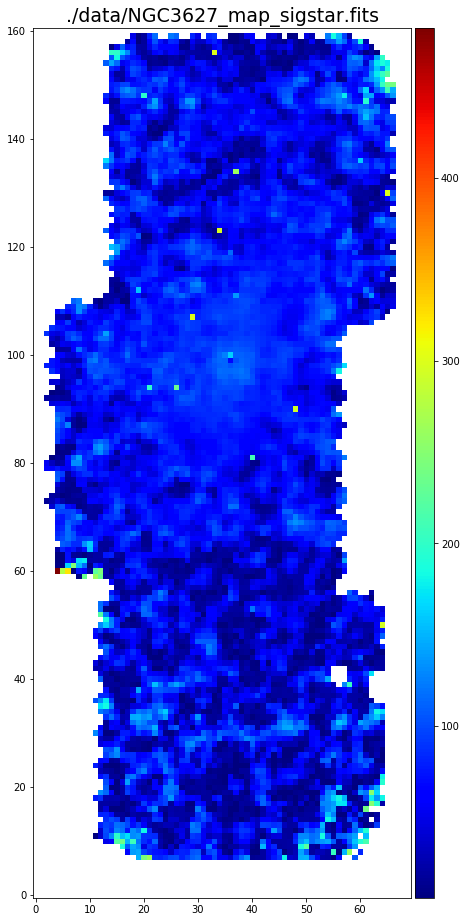

(161, 70)


In [17]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=[24,16])
ax = plt.gca()
fname = './data/NGC3627_map_sigstar.fits'
data = fits.getdata(fname)
im = plt.imshow(np.squeeze(data), origin='lower', cmap='jet')

plt.title(fname, fontsize=19)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()
print(data.shape[0:])

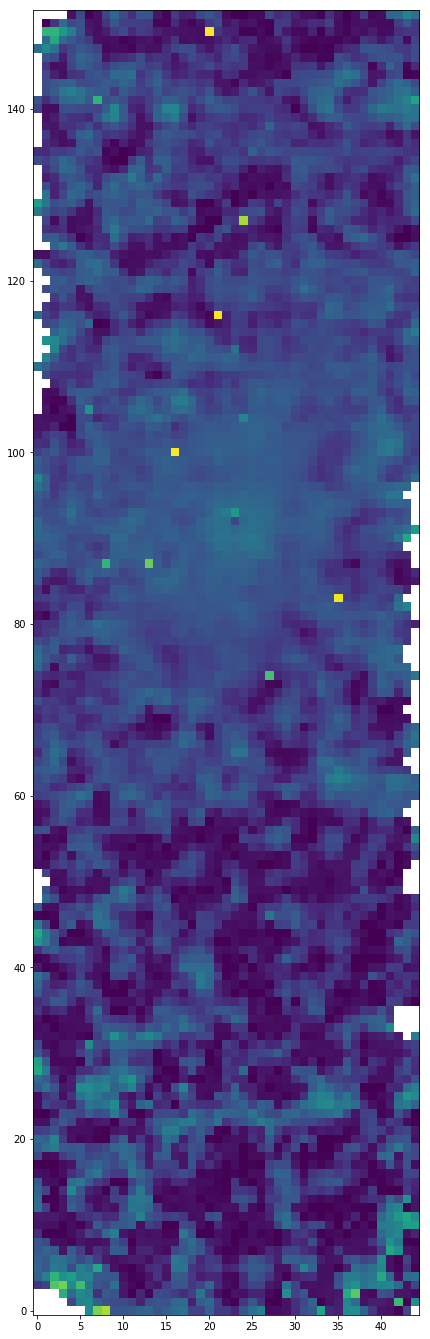

In [68]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
data = fits.getdata('./data/NGC3627_map_sigstar.fits')
data = np.squeeze(data)
fig=plt.figure(figsize=[8,24])
w = WCS('./data/NGC3627_map_sigstar.fits', naxis=2)
cposition= SkyCoord('{} {}'.format(w.wcs.crval[0], w.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')  
#size = u.Quantity((100, 800), u.pixel)
cutout = Cutout2D(data, (35.5,83),(152,45))

plt.imshow(cutout.data,origin='lower')
plt.show()


In [78]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
data = fits.getdata('./data/NGC3627_map_sigstar.fits')
data = np.squeeze(data)
fig=plt.figure(figsize=[8,24])
w = WCS('./data/NGC3627_map_sigstar.fits', naxis=2)
cposition= SkyCoord('{} {}'.format(w.wcs.crval[0], w.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')  
size = u.Quantity((252,145), u.arcsec)
cutout = Cutout2D(data, (170.08318266,12.93640067),size,wcs=w)

plt.imshow(cutout.data,origin='lower')
plt.show()

NoOverlapError: Arrays do not overlap.

<Figure size 576x1728 with 0 Axes>

In [5]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

def build_wcs(fits_name):
    data = fits.getdata(fits_name)
    data = np.squeeze(data)      #Зачем удалять одномерный массив?
    w = WCS(fname, naxis=2)    
#     header = fits.getheader(fits_name, naxis=2)
#     w = WCS(header)
    return w

def get_cutout(fits_name, size=(314, 106)):
    data = fits.getdata(fits_name)
    data = np.squeeze(data)
    w = WCS(fits_name, naxis=2)
    cposition= SkyCoord('{} {}'.format(w.wcs.crval[0], w.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')
#     print cposition
#     cposition= SkyCoord('24.176371524899999  15.7865508568', frame='fk5', unit='deg', equinox='J2000.0')
    cposition= SkyCoord('170.08318266 12.93640067', frame='fk5', unit='deg', equinox='J2000.0')
    
    size = u.Quantity(size, u.arcsec)
    cutout = Cutout2D(data, cposition, size, wcs=w)
    return cutout, w

def plot_cutout(fits_name, size=(314, 106), coordinates=True, figsize=[24, 8], colorbar=False, title=None, **kwargs):
    cutout, wcs = get_cutout(fits_name, size=size)
    
    # http://docs.astropy.org/en/stable/wcs/note_sip.html
    wcs.sip = None
    cutout.wcs.sip = None
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=cutout.wcs)
    im = ax.imshow(cutout.data, origin='lower', **kwargs)
    
#     print pixel_to_skycoord(104, 35, cutout.wcs)
#     print wcs.wcs_pix2world(104, 35,0)
#     print wcs.wcs_world2pix(cposition)
    
    lon = ax.coords[0]
    lat = ax.coords[1]
    if coordinates:
        lon.set_major_formatter('dd:mm:ss')
        lat.set_major_formatter('dd:mm:ss')

        lon.set_ticks(spacing=30. * u.arcsec)
        lat.set_ticks(spacing=30. * u.arcsec)

        lon.display_minor_ticks(True)
        lat.display_minor_ticks(True)
        lat.set_minor_frequency(3)
        lon.set_minor_frequency(3)
    else:
        lon.set_ticks_visible(False)
        lon.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)
        lon.set_axislabel('')
        lat.set_axislabel('')
    
#     ax.scatter(cposition.ra, cposition.dec, 100, color='r')
#     ax.scatter(35.18,  15.8, 100, color='m')
    cposition= SkyCoord('170.08318266 12.93640067', frame='fk5', unit='deg', equinox='J2000.0')
    spix = skycoord_to_pixel(cposition, cutout.wcs)
    ax.scatter(spix[0],  spix[1], 10, color='m')
    
    X,Y = np.meshgrid(np.arange(0.,60,1), np.arange(0.,160,1))
#     sig_los = Z[4:-1, 3:-2]
#     plt.plot(X[4:-1, 3:-2].ravel(), Y[4:-1, 3:-2].ravel(), '.', color='r', ms=0.5)
    
    
    if title is not None:
        ax.set_title(title + ':{}'.format(cutout.data.shape))
        
    if colorbar:
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(im, cax=cax)
        vmin,vmax = im.get_clim()
        #-- Defining a normalised scale
        cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        #-- Creating a new axes at the right side
        ax3 = fig.add_axes([0.9, 0.1, 0.03, 0.8])
        #-- Plotting the colormap in the created axes
        cb1 = matplotlib.colorbar.ColorbarBase(ax3, norm=cNorm)
#     plt.show()
    return cutout

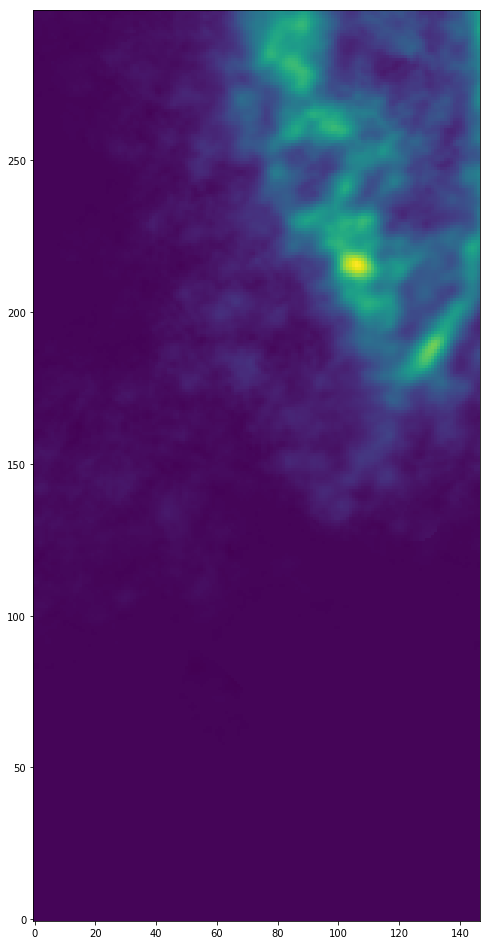

In [8]:
size = (450, 220)
#cutout = plot_cutout('./data/NGC_3627_NA_MOM0_THINGS.FITS', size=size, coordinates=True, figsize=[8, 24], title='sfr', vmax=1e-14)
from astropy.visualization.wcsaxes import SphericalCircle

cutout, wcs = get_cutout('./data/NGC_3627_NA_MOM0_THINGS.FITS', size=size)

fig = plt.figure(figsize=[8, 24])
#ax = fig.add_subplot(111, projection=cutout.wcs)
im = imshow(cutout.data, origin='lower')

#lon = ax.coords[0]
#lat = ax.coords[1]
#lon.set_major_formatter('dd:mm:ss')
#lat.set_major_formatter('dd:mm:ss')

#lon.set_ticks(spacing=30. * u.arcsec)
#lat.set_ticks(spacing=30. * u.arcsec)

#lon.display_minor_ticks(True)
#lat.display_minor_ticks(True)
#lat.set_minor_frequency(3)
#lon.set_minor_frequency(3)

# r = SphericalCircle((24.174042 * u.deg, 15.783472 * u.deg), 1500 * u.arcsec,
#                      edgecolor='yellow', facecolor='none', transform=ax.get_transform(cutout.wcs))
# ax.add_patch(r)
plt.show()

In [199]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u

def cut_fits(FirstFits = None, SecondFits = None, size = None):
    FirstData = fits.getdata(FirstFits)
    FirstData = np.squeeze(FirstData)
    FirstWCS = WCS(FirstFits, naxis = 2)
    cposition1 = SkyCoord('170.06318266 12.99640067'.format(FirstWCS.wcs.crval[0], FirstWCS.wcs.crval[1]), frame='icrs', unit='deg')
    
    SecondData = fits.getdata(SecondFits)
    SecondData = np.squeeze(SecondData)
    SecondWCS = WCS(SecondFits, naxis = 2)
    cposition2 = SkyCoord('{} {}'.format(SecondWCS.wcs.crval[0], SecondWCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')
    
    size = u.Quantity(size, u.arcsec)
    
    FirstData = Cutout2D(FirstData, cposition2, size, wcs = FirstWCS, mode='partial', fill_value=0.)
    SecondData = Cutout2D(SecondData, cposition2, size, wcs = SecondWCS, mode='partial', fill_value=0.)
    
    return FirstData, SecondData  

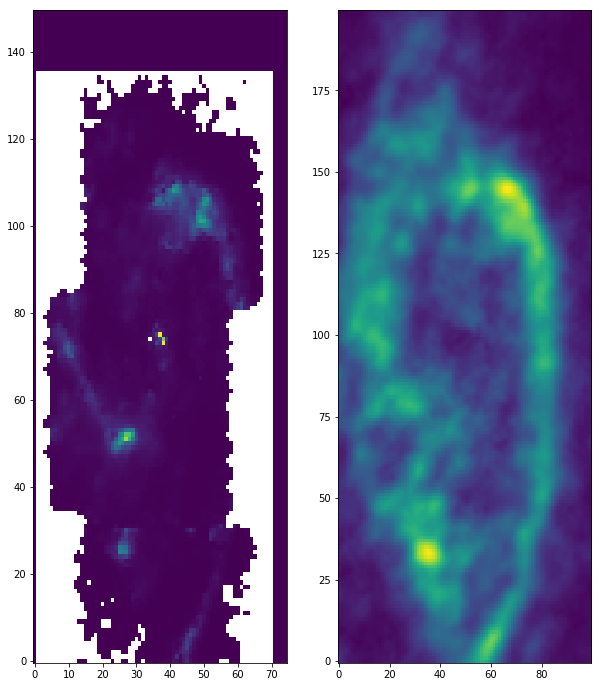

(150, 75)
(200, 100)


In [205]:
import matplotlib.pyplot as plt #Это можно не делать, если сверху уже %pylab

size = [300,150] # обратите внимание, что это в угловых секундах, а не в пикселях
FirstData, SecondData = cut_fits(FirstFits = './data/NGC3627_map_ha_corr.fits', SecondFits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 

fig, [ax, ax2] = plt.subplots(figsize=[10, 12], ncols=2)
ax.imshow(FirstData.data, origin='lower', aspect="auto")
ax2.imshow(SecondData.data, origin='lower', aspect="auto")
plt.show()

print(FirstData.shape)
print(SecondData.shape)  

То же самое, но не в пикселях, а с небесными координатами:

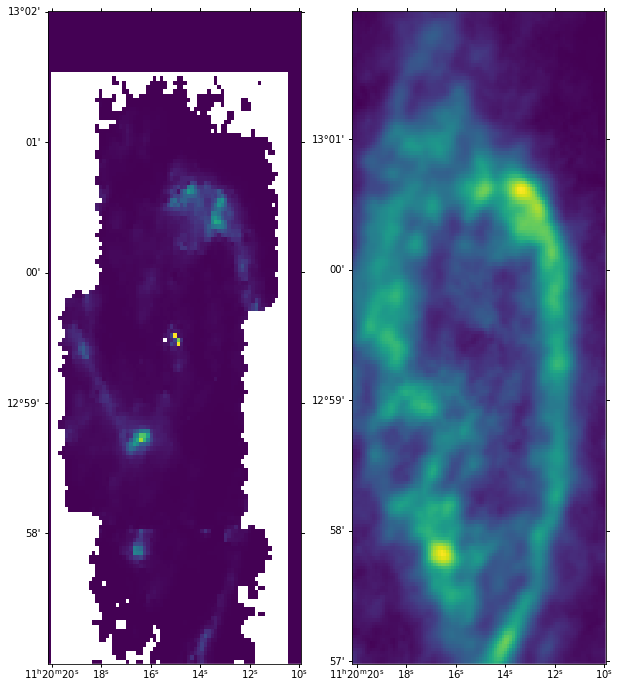

(150, 75)
(200, 100)


In [206]:
size = [300,150]
FirstData, SecondData = cut_fits(FirstFits = './data/NGC3627_map_ha_corr.fits', SecondFits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 
fig = plt.figure(figsize=[10, 12])
ax = fig.add_subplot(121, projection=FirstData.wcs)

ax.imshow(FirstData.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=SecondData.wcs)
ax2.imshow(SecondData.data, origin='lower', aspect="auto")

plt.show()

print(FirstData.shape)
print(SecondData.shape)  

Видно, что все как и должно быть - например по вертикали 300 угловых секунд, т.е. 5 минут - и вот они, как раз на y-оси отмечены.